In [2]:
import os
import sys
sys.path.append("..")
import numpy as np
import torch
from utils.matching import match_reconstruction_ground_truth
import pandas as pd
from utils import Timer, post_process_continuous
from attacks import train_and_attack_fed_avg
from models import FullyConnected
import matplotlib.pyplot as plt
import argparse
import pickle
from attacks import calculate_random_baseline
from datasets.base_dataset import BaseDataset
torch.set_printoptions(sci_mode=False)


In [3]:
configs = {
    # Inverting Gradients
    0: {
        'n_global_epochs': 1,
        'lr': 0.01,
        'shuffle': True,
        'attacked_clients': 'all',
        'attack_iterations': 1500,
        'reconstruction_loss': 'cosine_sim',
        'priors': None,
        'epoch_matching_prior': 'mean_squared_error',
        'post_selection': 1,
        'attack_learning_rate': 0.06,
        'return_all': False,
        'pooling': None,
        'perfect_pooling': False,
        'initialization_mode': 'uniform',
        'softmax_trick': False,
        'gumbel_softmax_trick': False,
        'sigmoid_trick': False,
        'temperature_mode': 'constant',
        'sign_trick': True,
        'verbose': False,
        'max_client_dataset_size': 32,
        'post_process_cont': False
    },
    # TabLeak
    52: {
        'n_global_epochs': 1,
        'lr': 0.01,
        'shuffle': True,
        'attacked_clients': 'all',
        'attack_iterations': 1500,
        'reconstruction_loss': 'cosine_sim',
        'priors': None,
        'epoch_matching_prior': 'mean_squared_error',
        'post_selection': 15,
        'attack_learning_rate': 0.06,
        'return_all': False,
        'pooling': 'median',
        'perfect_pooling': False,
        'initialization_mode': 'uniform',
        'softmax_trick': True,
        'gumbel_softmax_trick': False,
        'sigmoid_trick': True,
        'temperature_mode': 'constant',
        'sign_trick': True,
        'verbose': False,
        'max_client_dataset_size': 32,
        'post_process_cont': False
    }
}

In [5]:
client_models=[0,1,2,3]

client_models=[0]

In [4]:


def group_filter(client_gt_projected, client_recon_projected, index, value):
    # print("group_filter applied")
    print("index: ",index, "value: ",value)
    filtered_gt = client_gt_projected[client_gt_projected[:, index] == value]
    filtered_recon = client_recon_projected[client_gt_projected[:, index] == value]
    return filtered_gt, filtered_recon


def subgroup_filter(client_gt_projected, client_recon_projected, index1, value1, index2, value2):
    # print("subgroup_filter applied")
    print("index1: ", index1,"value1: ", value1, "index2: ",index2,"value2: ", value2)
    condition = (client_gt_projected[:, index1] == value1) & (client_gt_projected[:, index2] == value2)
    filtered_gt = client_gt_projected[condition]
    filtered_recon = client_recon_projected[condition]
    return filtered_gt, filtered_recon


In [8]:
recn_gt = f'../clients_data/reconstr_and_GT/inversion/normal/reconstructions_ground_truths_0.pkl'
dataset = f'../clients_data/reconstr_and_GT/inversion/normal/dataset_0.pkl'
tolerance_map = f'../clients_data/reconstr_and_GT/inversion/normal/tolerance_map_0.pkl'

with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

with open(recn_gt, 'rb') as file:
    recn_gt = pickle.load(file)

with open(dataset, 'rb') as file:
    dataset = pickle.load(file)

reconstructions = recn_gt['reconstructions']
ground_truths = recn_gt['ground_truths']

print(reconstructions[0][0].shape)
# print(reconstructions[0][0].requires_grad)
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
all_errors = []
cat_errors = []
cont_errors = []

rec_coll=[]
for i, lepochs in enumerate(local_epochs):
    for j, lbatch_size in enumerate(local_batch_sizes):
        for k, epoch_prior_param in enumerate(epoch_prior_params):
            for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
                # print("rec_shape 1",epoch_reconstruction[0].shape)
                # print(epoch_ground_truth[0].shape)

                for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
                        # print("rec_shape 2",client_reconstruction.shape)
                        # print(client_ground_truth.shape)
                        # print("loaded_dataloader val \n",client_reconstruction[2:3,:100])
                        

                        client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                        # print(client_recon_projected, )
                        # print(client_gt_projected, "\n")
                        column_names = [
                                    'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-Num', 'Marital-Status',
                                    'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-Gain', 'Capital-Loss',
                                    'Hours-per-week', 'Native-Country'
                                ]
                        df = pd.DataFrame(client_recon_projected, columns=column_names)

                        # Convert numerical columns to integers where applicable
                        numeric_cols = ['Age', 'Fnlwgt', 'Education-Num', 'Capital-Gain', 'Capital-Loss', 'Hours-per-week']
                        df[numeric_cols] = df[numeric_cols].astype(float).astype(int)

                        df1=pd.read_csv(f'../clients_data/raw_data/client_0.data', delimiter=',',names=column_names, engine='python')
                        # label_col = df1.iloc[:, -1]
                       
                        num_rows = len(df)
                        # print(df1)
                        # print(df1.iloc[:num_rows].values)

                        df['Income'] = df1.iloc[:num_rows, -1].values
                        
                        # df.to_csv("hello.data", index=False, header=False)
                        # client_recon_projected = np.load('synthetic_data_np.npy', allow_pickle=True)

                        reordered_reconstructed_batch, batch_cost_all, batch_cost_cat, batch_cost_cont  = match_reconstruction_ground_truth(client_gt_projected, client_recon_projected, tolerance_map)
      
                        # _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(client_gt_projected, client_recon_projected, tolerance_map)
                        all_errors.append(np.mean(batch_cost_all))
                        cat_errors.append(np.mean(batch_cost_cat))
                        cont_errors.append(np.mean(batch_cost_cont))

            collected_data[i, j, k, 0] = np.mean(all_errors), np.std(all_errors), np.median(all_errors), np.min(all_errors), np.max(all_errors)
            collected_data[i, j, k, 1] = np.mean(cat_errors), np.std(cat_errors), np.median(cat_errors), np.min(cat_errors), np.max(cat_errors)
            collected_data[i, j, k, 2] = np.mean(cont_errors), np.std(cont_errors), np.median(cont_errors), np.min(cont_errors), np.max(cont_errors)


best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()
print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')

print("\n\n")
idx=0
print(client_recon_projected[idx])  
# print(client_gt_projected[idx])          

torch.Size([2000, 105])
Performance at 5 Epochs and 8 Batch Size: 68.5% +- 0.00



['36.0' 'Private' '181261.0' 'HS-grad' '10.0' 'Divorced'
 'Transport-moving' 'Not-in-family' 'White' 'Male' '38.0' '77.0' '39.0'
 'United-States']


In [5]:
# np.save('reordered_reconstructed_batch.npy', reordered_reconstructed_batch)

In [6]:
reordered_reconstructed_batch=np.load('reordered_reconstructed_batch.npy')

column_names = [
            'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-Num', 'Marital-Status',
            'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-Gain', 'Capital-Loss',
            'Hours-per-week', 'Native-Country'
        ]
df = pd.DataFrame(reordered_reconstructed_batch, columns=column_names)

# Convert numerical columns to integers where applicable
numeric_cols = ['Age', 'Fnlwgt', 'Education-Num', 'Capital-Gain', 'Capital-Loss', 'Hours-per-week']
df[numeric_cols] = df[numeric_cols].astype(float).astype(int)

column_names1 = [
            'Age', 'Workclass', 'Fnlwgt', 'Education', 'Education-Num', 'Marital-Status',
            'Occupation', 'Relationship', 'Race', 'Sex', 'Capital-Gain', 'Capital-Loss',
            'Hours-per-week', 'Native-Country',"Income"
        ]
df1=pd.read_csv(f'../clients_data/raw_data/client_0.data', delimiter=',',names=column_names1, engine='python')
# label_col = df1.iloc[:, -1]

num_rows = len(df)
# print(df1)
# print(df1.iloc[:num_rows].values)

df['Income'] = df1.iloc[:num_rows, -1].values

# df.to_csv("hello.data", index=False, header=False)

print(len(df))
df.head()

2000


,Age,Workclass,Fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Native-Country,Income
0,36,Private,172974,HS-grad,10,Never-married,Machine-op-inspct,Own-child,White,Male,-95,24,39,United-States,<=50K
1,37,Self-emp-inc,189901,Bachelors,10,Married-civ-spouse,Exec-managerial,Not-in-family,Amer-Indian-Eskimo,Male,631,2414,74,United-States,<=50K
2,86,Self-emp-not-inc,182707,Prof-school,18,Married-civ-spouse,Prof-specialty,Wife,White,Male,1098,59,40,United-States,>50K
3,71,Private,246104,Some-college,14,Married-civ-spouse,Exec-managerial,Not-in-family,White,Male,1101,66,77,United-States,<=50K
4,36,Private,174460,HS-grad,10,Never-married,Other-service,Not-in-family,White,Male,-95,20,39,United-States,<=50K


In [7]:
df1.head()

,Age,Workclass,Fnlwgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-per-week,Native-Country,Income
0,30,Private,169186,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,60,United-States,<=50K
1,46,Self-emp-inc,67725,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,10,United-States,<=50K
2,54,Self-emp-not-inc,83311,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,30,United-States,>50K
3,70,Self-emp-inc,232871,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,30,United-States,<=50K
4,54,Private,141663,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,15,United-States,<=50K


In [ ]:
attr="Capital-Loss"
df1[df1[attr] > 0].shape[0], df[df[attr] >0].shape[0]

(96, 2000)

In [9]:
df["Race"].value_counts(), df1["Race"].value_counts()

(White                 1528
 Black                  283
 Asian-Pac-Islander     112
 Amer-Indian-Eskimo      48
 Other                   29
 Name: Race, dtype: int64,
 White                 1720
 Black                  193
 Asian-Pac-Islander      58
 Amer-Indian-Eskimo      20
 Other                    9
 Name: Race, dtype: int64)

In [ ]:
df=df[df["Age"]<=100]
df.loc[df["Capital-Gain"] < 0, "Capital-Gain"] = 0

df[df[attr] <0].shape[0]
# df.to_csv("hello.data", index=False, header=False)

In [37]:
recn_gt = f'../clients_data/reconstr_and_GT/inversion/normal/reconstructions_ground_truths_0.pkl'
dataset = f'../clients_data/reconstr_and_GT/inversion/normal/dataset_0.pkl'
tolerance_map = f'../clients_data/reconstr_and_GT/inversion/normal/tolerance_map_0.pkl'

with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

with open(recn_gt, 'rb') as file:
    recn_gt = pickle.load(file)

with open(dataset, 'rb') as file:
    dataset = pickle.load(file)

reconstructions = recn_gt['reconstructions']
ground_truths = recn_gt['ground_truths']

# print(reconstructions[0][0].shape)
# print(reconstructions[0][0].requires_grad)
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
all_errors = []
cat_errors = []
cont_errors = []

batch_cost_all_collect=[]
batch_cost_cat_collect=[] 
batch_cost_cont_collect=[]

rec_coll=[]
for i, lepochs in enumerate(local_epochs):
    for j, lbatch_size in enumerate(local_batch_sizes):
        for k, epoch_prior_param in enumerate(epoch_prior_params):
            for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
                # print("rec_shape 1",epoch_reconstruction[0].shape)
                # print(epoch_ground_truth[0].shape)

                for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
                        # print("rec_shape 2",client_reconstruction.shape)
                        # print(client_ground_truth.shape)
                        # print("loaded_dataloader val \n",client_reconstruction[2:3,:100])
                        

                        client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                        # print(client_recon_projected, )
                        # print(client_gt_projected, "\n")
                        # loaded_array = np.load('synthetic_data_np.npy', allow_pickle=True)
                        # client_recon_projected_1= loaded_array
                        # print("client_recon_projected_1: ",client_recon_projected_1.shape)
                        # _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(client_gt_projected, client_recon_projected_1, tolerance_map)

                        client_recon_projected_all = np.load('all_chunks.npy', allow_pickle=True)

                        for i in range(len(client_recon_projected_all)):
                            
                            client_recon_projected= client_recon_projected_all[i]
                            print("client_recon_projected: ",client_recon_projected.shape)
                        
                            _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(client_gt_projected, client_recon_projected, tolerance_map)
                            batch_cost_all_collect.append(batch_cost_all)
                            batch_cost_cat_collect.append(batch_cost_cat)
                            batch_cost_cont_collect.append(batch_cost_cont)

                        # all_errors.append(np.mean(batch_cost_all_collect))
                        # cat_errors.append(np.mean(batch_cost_all_collect))
                        # cont_errors.append(np.mean(batch_cost_all_collect))                        
                        
                        # all_errors.append(np.mean(batch_cost_all))
                        # cat_errors.append(np.mean(batch_cost_cat))
                        # cont_errors.append(np.mean(batch_cost_cont))

            # collected_data[i, j, k, 0] = np.mean(all_errors), np.std(all_errors), np.median(all_errors), np.min(all_errors), np.max(all_errors)
            # collected_data[i, j, k, 1] = np.mean(cat_errors), np.std(cat_errors), np.median(cat_errors), np.min(cat_errors), np.max(cat_errors)
            # collected_data[i, j, k, 2] = np.mean(cont_errors), np.std(cont_errors), np.median(cont_errors), np.min(cont_errors), np.max(cont_errors)


# best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()
# print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')

# print("\n\n")
# idx=0
# print(client_recon_projected[idx])  
# print(client_gt_projected[idx])          

client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)
client_recon_projected:  (2000, 14)


In [46]:
np.__version__

'1.21.0'

In [28]:
batch_cost_all_collect[0],batch_cost_cat_collect[0] ,batch_cost_cont_collect[0]

(array([0.35714286, 0.5       , 0.71428571, ..., 0.21428571, 0.35714286,
        0.35714286]),
 array([0.   , 0.375, 0.625, ..., 0.   , 0.25 , 0.375]),
 array([0.83333333, 0.66666667, 0.83333333, ..., 0.5       , 0.5       ,
        0.33333333]))

In [45]:
# collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
for m in range(len(client_recon_projected_all)):
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):

                all_errors.append(np.mean(batch_cost_all_collect[m]))
                cat_errors.append(np.mean(batch_cost_cat_collect[m]))
                cont_errors.append(np.mean(batch_cost_cont_collect[m]))                        

                # np.mean(all_errors)
                collected_data[i, j, k, 0] = np.mean(all_errors), np.std(all_errors), np.median(all_errors), np.min(all_errors), np.max(all_errors)
                collected_data[i, j, k, 1] = np.mean(cat_errors), np.std(cat_errors), np.median(cat_errors), np.min(cat_errors), np.max(cat_errors)
                collected_data[i, j, k, 2] = np.mean(cont_errors), np.std(cont_errors), np.median(cont_errors), np.min(cont_errors), np.max(cont_errors)


    best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()
    print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')

    print(m)

Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
0
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
1
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
2
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
3
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
4
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
5
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
6
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
7
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
8
Performance at 5 Epochs and 8 Batch Size: 58.6% +- 0.15
9


In [23]:
loaded_array = np.load('synthetic_data_np.npy', allow_pickle=True)
loaded_array.shape

(2000, 14)

In [ ]:
loaded_array = np.load('all_chunks.npy', allow_pickle=True)
loaded_array[:1]

(2000, 14)

In [ ]:
client_recon_projected_all = np.load('all_chunks.npy', allow_pickle=True)

client_recon_projected_all[0][:1]

# for i in range(len(client_recon_projected_all)):
    # print(client_recon_projected_all[i].shape)
    # # client_recon_projected= client_recon_projected[i]

(2000, 14)
(2000, 14)
(2000, 14)
(2000, 14)
(2000, 14)
(2000, 14)
(2000, 14)
(2000, 14)
(2000, 14)
(2000, 14)


In [16]:
print(type(client_recon_projected))
print(client_recon_projected.shape)
print(client_recon_projected[0])  

<class 'numpy.ndarray'>
(2000, 14)
['36.0' 'Private' '181261.0' 'HS-grad' '10.0' 'Divorced'
 'Transport-moving' 'Not-in-family' 'White' 'Male' '38.0' '77.0' '39.0'
 'United-States']


In [8]:
tmp=(torch.rand(8,105) - 0.5) * 2
tmp[:1,:10]

tensor([[-0.5084, -0.6523,  0.5889,  0.8196, -0.0622, -0.5345, -0.8190, -0.0338,
          0.5393,  0.9499]])

# Normal training

In [9]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/normal/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/normal/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/normal/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}

    index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]
    
    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)  
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Normal attack
----------- Model_name --------------:  0


FileNotFoundError: [Errno 2] No such file or directory: '../clients_data/reconstr_and_GT/normal/reconstructions_ground_truths_0.pkl'

In [10]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


IndexError: list index out of range

In [10]:
all_state_recon

{0: 56.82857142857143}

In [8]:
filename_all_state_inversion = "inversion_normal_adult_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


All state reconstructed data has been stored in inversion_normal_adult_reconstruction.pickle


In [11]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }



all_errors [[0.42404748070058934], [0.5634071810542398], [0.39322751322751326], [0.5621978021978022]]


In [12]:
final_group_reco

{0: {'Male': 57.59525192994106,
  'Female': 43.65928189457602,
  'White': 60.67724867724868,
  'Black': 43.780219780219774}}

In [11]:

filename_all_state_inversion_group = "inversion_normal_adult_group_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

Group reconstructed data has been stored in inversion_normal_adult_group_reconstruction.pickle


In [14]:
(60+43)/2

51.5

# DP training

In [15]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/dp/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/dp/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/dp/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)        
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Normal attack
----------- Model_name --------------:  0
(2000, 14) (2000, 14)
index:  8 value:  White
(1697, 14) (1697, 14)
index:  8 value:  Black
(203, 14) (203, 14)
index:  9 value:  Male
(1379, 14) (1379, 14)
index:  9 value:  Female
(621, 14) (621, 14)


In [16]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [17]:
all_state_recon

{0: 60.58571428571429}

In [18]:
filename_all_state_inversion = "inversion_dp_adult_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


All state reconstructed data has been stored in inversion_dp_adult_reconstruction.pickle


In [19]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }



all_errors [[0.3976765721020287], [0.5024630541871922], [0.4261887496115197], [0.44616977225672877]]


In [27]:
final_group_reco

{0: {'Male': 46.10389610389611,
  'Female': 19.047619047619058,
  'White': 44.64285714285714,
  'Black': 25.0}}

In [20]:

filename_all_state_inversion_group = "inversion_dp_adult_group_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

Group reconstructed data has been stored in inversion_dp_adult_group_reconstruction.pickle


# Fair Training

In [21]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/fair/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/fair/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/fair/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)        
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Normal attack
----------- Model_name --------------:  0
(16, 14) (16, 14)
index:  8 value:  White
(11, 14) (11, 14)
index:  8 value:  Black
(3, 14) (3, 14)
index:  9 value:  Male
(12, 14) (12, 14)
index:  9 value:  Female
(4, 14) (4, 14)


In [22]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [23]:
all_state_recon

{0: 43.75}

In [24]:
filename_all_state_inversion = "inversion_fair_adult_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


All state reconstructed data has been stored in inversion_fair_adult_reconstruction.pickle


In [25]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }



all_errors [[0.5389610389610389], [0.8095238095238094], [0.5535714285714286], [0.75]]


In [28]:
final_group_reco

{0: {'Male': 46.10389610389611,
  'Female': 19.047619047619058,
  'White': 44.64285714285714,
  'Black': 25.0}}

In [26]:

filename_all_state_inversion_group = "inversion_fair_adult_group_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

Group reconstructed data has been stored in inversion_fair_adult_group_reconstruction.pickle


# FairDP training

In [24]:
exp1 = "tableak_FT_inversion_normal"
config = configs[0]
final_grp={}
final_subgrp={}

print("Inversion Normal attack")
num_training_datapoints=2000

final_all_errors = []
final_cat_errors = []
final_cont_errors = []

final_all_errors_full = []
final_cat_errors_full = []
final_cont_errors_full = []


for model_name in client_models:
    print("----------- Model_name --------------: ",model_name)
    temp_result={}
    
    # recn_gt = f'../../{exp1}/50_clients_data/reconstr_and_GT/reconstructions_ground_truths_{model_name}.pkl'
    # dataset = f'../../{exp1}/50_clients_data/reconstr_and_GT/dataset_{model_name}.pkl'
    # tolerance_map = f'../../{exp1}/50_clients_data/reconstr_and_GT/tolerance_map_{model_name}.pkl'

    recn_gt = f'../clients_data/reconstr_and_GT/fairdp/reconstructions_ground_truths_{model_name}.pkl'
    dataset = f'../clients_data/reconstr_and_GT/fairdp/dataset_{model_name}.pkl'
    tolerance_map = f'../clients_data/reconstr_and_GT/fairdp/tolerance_map_{model_name}.pkl'

    with open(recn_gt, 'rb') as file:
        recn_gt = pickle.load(file)

    with open(dataset, 'rb') as file:
        dataset = pickle.load(file)
    
    with open(tolerance_map, 'rb') as file:
        tolerance_map = pickle.load(file)

    reconstructions = recn_gt['reconstructions']
    ground_truths = recn_gt['ground_truths']

    all_errors = []
    cat_errors = []
    cont_errors = []
    
    all_errors_full = []
    cat_errors_full = []
    cont_errors_full = []
    
    temp_all_errors = []
    temp_cat_errors = []
    temp_cont_errors = []
    
    match_results = {}
    index_value_pairs = [(8, "White"),(8,"Black"), (9, "Male"), (9, "Female")]

    for epoch_reconstruction, epoch_ground_truth in zip(reconstructions, ground_truths):
        for client_reconstruction, client_ground_truth in zip(epoch_reconstruction, epoch_ground_truth):
            if config['post_process_cont']:
                client_reconstruction = post_process_continuous(client_reconstruction, dataset=dataset)
            client_recon_projected, client_gt_projected = dataset.decode_batch(client_reconstruction, standardized=True), dataset.decode_batch(client_ground_truth, standardized=True)
                    
            print(client_gt_projected.shape, client_recon_projected.shape)
                    
            _, batch_cost_all_original, batch_cost_cat_original, batch_cost_cont_original = match_reconstruction_ground_truth(
                                client_gt_projected, client_recon_projected, tolerance_map
                                )
            all_errors_full.append(np.mean(batch_cost_all_original))
            cat_errors_full.append(np.mean(batch_cost_cat_original))
            cont_errors_full.append(np.mean(batch_cost_cont_original))  

            final_all_errors_full.append(all_errors_full)
            final_cat_errors_full.append(cat_errors_full)
            final_cont_errors_full.append(cont_errors_full) 
            
            for index, value in index_value_pairs:

                temp_all_errors = []
                temp_cat_errors = []
                temp_cont_errors = []
            
                filtered_gt, filtered_recon = group_filter(client_gt_projected, client_recon_projected, index=index, value=value)        
                print(filtered_gt.shape, filtered_recon.shape)
    
                # Call match_reconstruction_ground_truth with the filtered results
                _, batch_cost_all, batch_cost_cat, batch_cost_cont = match_reconstruction_ground_truth(filtered_gt, filtered_recon, tolerance_map)
                
                temp_all_errors.append(np.mean(batch_cost_all))
                temp_cat_errors.append(np.mean(batch_cost_cat))
                temp_cont_errors.append(np.mean(batch_cost_cont))  
    
                all_errors.append(temp_all_errors)
                cat_errors.append(temp_cat_errors)
                cont_errors.append(temp_cont_errors) 
                
            final_all_errors.append(all_errors)
            final_cat_errors.append(cat_errors)
            final_cont_errors.append(cont_errors)         

Inversion Normal attack
----------- Model_name --------------:  0
(16, 14) (16, 14)
index:  8 value:  White
(11, 14) (11, 14)
index:  8 value:  Black
(3, 14) (3, 14)
index:  9 value:  Male
(12, 14) (12, 14)
index:  9 value:  Female
(4, 14) (4, 14)
----------- Model_name --------------:  1
(16, 14) (16, 14)
index:  8 value:  White
(12, 14) (12, 14)
index:  8 value:  Black
(3, 14) (3, 14)
index:  9 value:  Male
(14, 14) (14, 14)
index:  9 value:  Female
(2, 14) (2, 14)


In [25]:
local_epochs=[5]
local_batch_sizes=[8]
epoch_prior_params=[0.01]
all_state_recon={}

for m,model_name in enumerate(client_models):
    collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))
    
    for i, lepochs in enumerate(local_epochs):
        for j, lbatch_size in enumerate(local_batch_sizes):
            for k, epoch_prior_param in enumerate(epoch_prior_params):
    
                collected_data[i, j, k, 0] = np.mean(final_all_errors_full[m]), np.std(final_all_errors_full[m]), np.median(final_all_errors_full[m]), np.min(final_all_errors_full[m]), np.max(final_all_errors_full[m])
                collected_data[i, j, k, 1] = np.mean(final_cat_errors_full[m]), np.std(final_cat_errors_full[m]), np.median(final_cat_errors_full[m]), np.min(final_cat_errors_full[m]), np.max(final_cat_errors_full[m])
                collected_data[i, j, k, 2] = np.mean(final_cont_errors_full[m]), np.std(final_cont_errors_full[m]), np.median(final_cont_errors_full[m]), np.min(final_cont_errors_full[m]), np.max(final_cont_errors_full[m])
    
            best_param_index = np.argmin(collected_data[i, j, :, 0, 0]).item()

    temp_var=float(100 * (1 - collected_data[i, j, best_param_index, 0, 0]))
    all_state_recon[model_name]=temp_var
    # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[i, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[i, j, best_param_index, 0, 1]:.2f}')
    # total_recon= 100 * (1 - collected_data[i, j, best_param_index, 0, 0])
    # print("total_recon: ",total_recon)


In [26]:
all_state_recon

{0: 40.625, 1: 41.51785714285714}

In [27]:
filename_all_state_inversion = "inversion_fairdp_adult_reconstruction.pickle"

with open(filename_all_state_inversion, 'wb') as file:
    pickle.dump(all_state_recon, file)

print(f"All state reconstructed data has been stored in {filename_all_state_inversion}")


All state reconstructed data has been stored in inversion_fairdp_adult_reconstruction.pickle


In [28]:

local_epochs = [5]
local_batch_sizes = [8]
epoch_prior_params = [0.01]
final_group_reco={}
for m,model_name in enumerate(client_models):
    
    temp_group_score=[]
    all_errors =final_all_errors[m]
    cat_errors=final_cat_errors[m]
    cont_errors=final_cont_errors[m]
    print("all_errors",all_errors)
    for i in range(len(all_errors)):
        collected_data = np.zeros((len(local_epochs), len(local_batch_sizes), len(epoch_prior_params), 3, 5))

        for m, lepochs in enumerate(local_epochs): 
            for j, lbatch_size in enumerate(local_batch_sizes):
                for k, epoch_prior_param in enumerate(epoch_prior_params):
                    
                    collected_data[m, j, k, 0] = np.mean(all_errors[i]), np.std(all_errors[i]), np.median(all_errors[i]), np.min(all_errors[i]), np.max(all_errors[i])
                    collected_data[m, j, k, 1] = np.mean(cat_errors[i]), np.std(cat_errors[i]), np.median(cat_errors[i]), np.min(cat_errors[i]), np.max(cat_errors[i])
                    collected_data[m, j, k, 2] = np.mean(cont_errors[i]), np.std(cont_errors[i]), np.median(cont_errors[i]), np.min(cont_errors[i]), np.max(cont_errors[i])
    
                best_param_index = np.argmin(collected_data[m, j, :, 0, 0]).item()
    
            # print("best_param_index", best_param_index)
            # print(f'Performance at {lepochs} Epochs and {lbatch_size} Batch Size: {100*(1-collected_data[m, j, best_param_index, 0, 0]):.1f}% +- {100*collected_data[m, j, best_param_index, 0, 1]:.2f}')
            temp_var=float(100 * (1 - collected_data[m, j, best_param_index, 0, 0]))
            temp_group_score.append(temp_var)
            
        # print(temp_group_score)
        
    final_group_reco[model_name] = {
        "Male":temp_group_score[0],
        "Female":temp_group_score[1] ,
        "White":temp_group_score[2] ,
        "Black": temp_group_score[3]
    }



all_errors [[0.6038961038961038], [0.6904761904761906], [0.5952380952380952], [0.6607142857142857]]
all_errors [[0.5833333333333334], [0.7142857142857143], [0.5969387755102041], [0.75]]


In [29]:

filename_all_state_inversion_group = "inversion_fairdp_adult_group_reconstruction.pickle"

with open(filename_all_state_inversion_group, 'wb') as file:
    pickle.dump(final_group_reco, file)

print(f"Group reconstructed data has been stored in {filename_all_state_inversion_group}")

Group reconstructed data has been stored in inversion_fairdp_adult_group_reconstruction.pickle


In [30]:
inversion_normal_group = "inversion_normal_adult_group_reconstruction.pickle"
inversion_dp_group = "inversion_dp_adult_group_reconstruction.pickle"
inversion_fair_group = "inversion_fair_adult_group_reconstruction.pickle"
inversion_fairdp_group = "inversion_fairdp_adult_group_reconstruction.pickle"



In [31]:



with open(inversion_normal_group, 'rb') as file:
    inversion_normal_group_reconstruction = pickle.load(file)


with open(inversion_dp_group, 'rb') as file:
    inversion_dp_group_reconstruction = pickle.load(file)

 
with open(inversion_fair_group, 'rb') as file:
    inversion_fair_group_reconstruction = pickle.load(file)


   
with open(inversion_fairdp_group, 'rb') as file:
    inversion_fairdp_group_reconstruction = pickle.load(file)




In [32]:
df_inversion_normal_group_reconstruction = pd.DataFrame(inversion_normal_group_reconstruction).T
df_inversion_normal_group_reconstruction.index.name = 'State'
df_inversion_normal_group_reconstruction.reset_index(inplace=True)

df_inversion_dp_group_reconstruction = pd.DataFrame(inversion_dp_group_reconstruction).T
df_inversion_dp_group_reconstruction.index.name = 'State'
df_inversion_dp_group_reconstruction.reset_index(inplace=True)

df_inversion_fair_group_reconstruction = pd.DataFrame(inversion_fair_group_reconstruction).T
df_inversion_fair_group_reconstruction.index.name = 'State'
df_inversion_fair_group_reconstruction.reset_index(inplace=True)


df_inversion_fairdp_group_reconstruction = pd.DataFrame(inversion_fairdp_group_reconstruction).T
df_inversion_fairdp_group_reconstruction.index.name = 'State'
df_inversion_fairdp_group_reconstruction.reset_index(inplace=True)




In [33]:
df_inversion_normal_group_reconstruction.head()

,State,Male,Female,White,Black
0,0,46.753247,23.809524,45.238095,30.357143
1,1,47.619048,42.857143,51.020408,17.857143


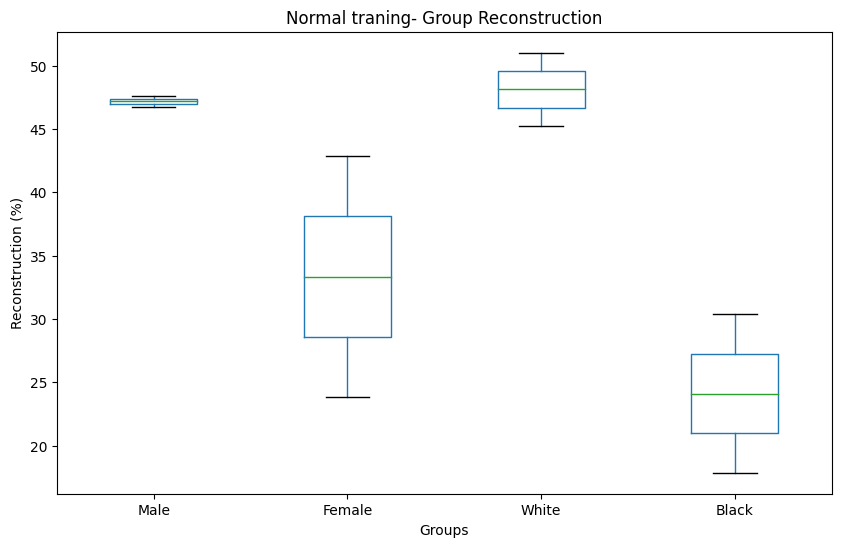

In [34]:
plt.figure(figsize=(10, 6))
df_inversion_normal_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("Normal traning- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

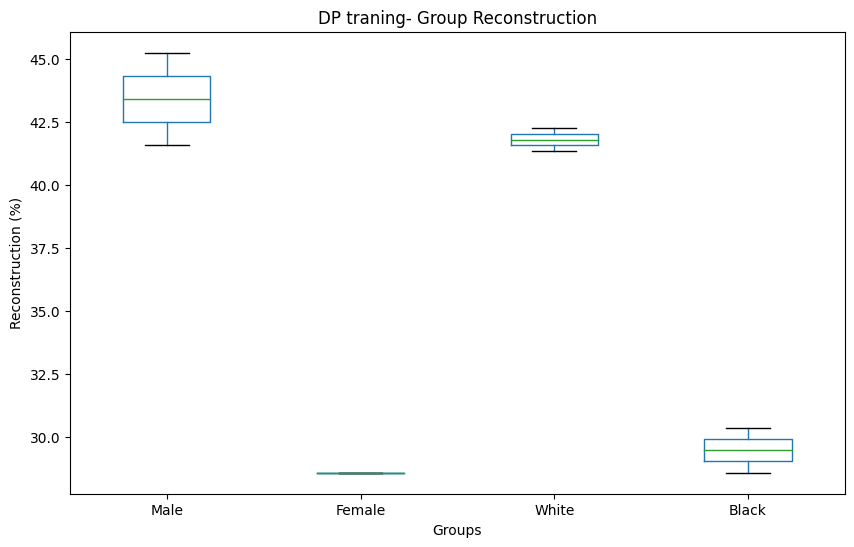

In [35]:

plt.figure(figsize=(10, 6))
df_inversion_dp_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("DP traning- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

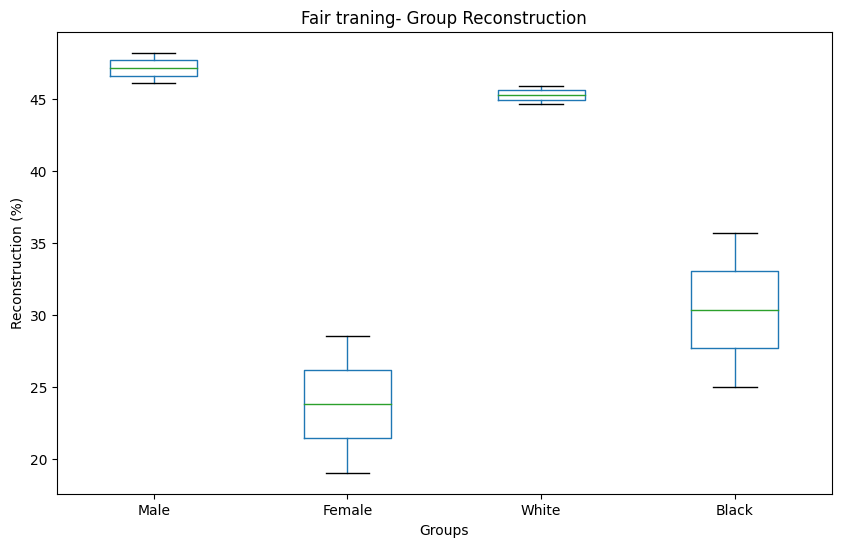

In [36]:

plt.figure(figsize=(10, 6))
df_inversion_fair_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("Fair traning- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()

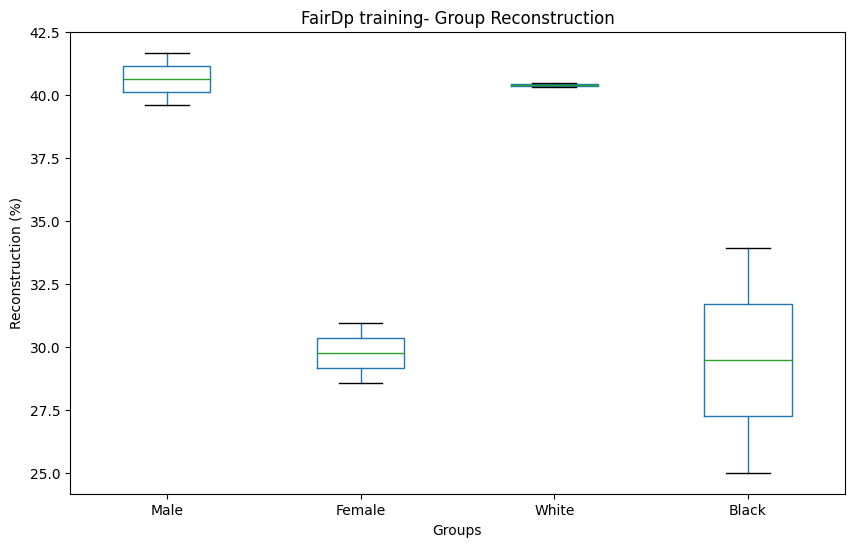

In [37]:

plt.figure(figsize=(10, 6))
df_inversion_fairdp_group_reconstruction[['Male', 'Female', 'White', 'Black']].boxplot()
plt.title("FairDp training- Group Reconstruction")
plt.ylabel("Reconstruction (%)")
plt.xlabel("Groups")
plt.grid(False)
plt.show()